Ustawienia wyświetlania:

In [2]:
# encoding=utf8  
#import sys  
#reload(sys)  
#sys.setdefaultencoding('utf8')
% matplotlib inline
import matplotlib

matplotlib.rcParams['figure.figsize'] = (7,7)
matplotlib.rcParams.update({'font.family': 'Arial'})
matplotlib.rcParams.update({'font.size': 10})

#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))

from ipywidgets import interact
import matplotlib.pyplot as plt

Importy:

In [3]:
import numpy as np
import scipy.signal as ss

Definicje potrzebnych funkcji:

In [4]:
def czas(T = 1.0, Fs = 128.0):
    dt = 1.0/Fs
    t = np.arange(0,T,dt)
    return t

def gabor(t0 = 0.5, sigma = 0.1, T = 1.0, f=10, phi = 0, Fs = 128.0):
    t = czas(T,Fs)
    s = np.exp(-((t-t0)/(sigma))**2/2) * np.cos(2*np.pi*f*(t-t0) + phi)
    return s
 
def sin(f = 10.0, T = 1.0, Fs = 128.0, phi =0 ):
    '''
    sin o zadanej cz?sto?ci (w Hz), d?ugo?ci, fazie i cz?sto?ci próbkowania
    Domy?lnie wytwarzany jest sygna? reprezentuj?cy 
    1 sekund? sinusa o cz?sto?ci 1Hz i zerowej fazie próbkowanego 128 Hz
    '''
    t = czas(T,Fs)
    s = np.sin(2*np.pi*f*t + phi)
    return s
 
def chirp(f0,fk,T,Fs):
    '''
    f0 - częstość początkowa
    fk - częstość końcowa
    T - długość trwania
    Fs  -częstość próbkowania
    '''
    t = czas(T,Fs)
    f  = f0 + (fk-f0)/2.0/(T)*t
    s  = np.cos(2*np.pi*t*f)
    return s

def TFRPlot(TFR, t_mapy, f_mapy, sig, Fs=128,title =''):
    '''
    Funkcja do rysowania map czas-częstość z sygnałem zaprezentowanym poniżej
    TFR - mapa czas-częstość (time-freqyency representation
    t_mapy, f_mapy - wektory reprezentujące osie czasu i częstości
    sig - sygnał do wyrysowania pod mapą (np. ten, z którego powstała mapa)
    Fs - częstość próbkowania sygnału 
    title - tytuł do wyświetlenia ponad mapą
    '''
    df = f_mapy[1]-f_mapy[0]
    dt = t_mapy[1]-t_mapy[0]
    t = np.arange(0,len(sig))/Fs
    sygAxes = plt.axes([0.05, 0.05, 0.8, 0.1])
    tfAxes = plt.axes([0.05, 0.15, 0.8, 0.8])
    sygAxes.plot(t,sig)
    plt.xlim((t_mapy.min(), t_mapy.max()))
    #py.setp(sygAxes, yticklabels=[])
    tfAxes.imshow(TFR,aspect='auto',origin='lower',interpolation='nearest', 
                  extent=(t_mapy.min()-dt/2,t_mapy.max()+dt/2,f_mapy.min()-df/2,f_mapy.max()+df/2))
    plt.setp(tfAxes,xticklabels=[])
    plt.title(title)
    plt.show()

# Ćwiczenia z analizy sygnałów: Analiza czas-częstość; rozkład na atomy

## Krótko czasowa transformata Fouriera

### Definicja
Krótko czasowa transformata Fouriera (STFT) może być rozumiana jako seria transformat Fouriera wykonanych na sygnale okienkowanym, przy czym położenie okienka w czasie jest w ramach takiej serii przesuwane monotonicznie. 

W wersji ciągłej możemy to zapisać tak:

$F_x(t,f; h)= \int_{-\infty}^{\infty}{x(u) h^*(u-t)e^{- i 2 \pi u f} du} $

### Odwrotność STFT - interpretacja "atomowa" transformaty STFT
Jeśli okienko ma skończoną energię to STFT jest transformatą odwracalną i można odzyskać z niej sygnał w reprezentacji czasowej:

$x(t) = \frac{1}{E_h}\int_{-\infty}^{\infty}\int_{-\infty}^{\infty}F_x(u,f;h)h(t-u)e^{i 2\pi t f}\,du\,df $

gdzie $E_h=\int_{-\infty}^{\infty}|h(t)|^2\,dt $ zaś $F_x(u,f;h)$ dla ustalonego okna ($h$), ustalonego położenia w czasie ($u$) i częstości ($f$) jest liczbą (współczynnikiem).

Tak więc sygnał może być rozłożony na liniową kombinację elementarnych falek 'atomów' postaci:

$h_{t,f}(u)=h(u-t)e^{i 2 \pi f u}$

Każdy atom uzyskiwany jest przez translację pojedynczego okna $h$ w czasie i jego modulację częstością $f$. 

#### Jak wyglądaja takie 'atomy'?

In [5]:
def atom_tf(f ,t ,h_len):
    Fs = 256
    T= 10
    t_idx = int(t*Fs)
    
    
    u = np.arange(0,T,1/Fs)
    h = np.zeros(len(u))
    h_tmp = np.hamming(h_len) #np.hamming itp.
    h[t_idx:t_idx+h_len] = h_tmp
    
    atom = h * np.exp(2j* np.pi* f* u) 
    
    plt.plot(u,atom.real,'b')
    plt.plot(u,h,'r')
    plt.xlim((0,10))
    plt.legend(('atom','okno'))
    plt.show()

    
interact(atom_tf, f = (1,17,1),t = (0,7,0.1), h_len =(2,512,16))




A Jupyter Widget

<function __main__.atom_tf>

### STFT a gęstość energii w przestrzeni czas-częstość
Spektrogram: kwadrat modułu STFT, jest estymatą gęstości energi w przestrzeni czas-częstść:

$S_x(t, f) =\left|\int_{-\infty}^{\infty}{x(u) h^*(u - t) e^{-i 2\pi f u} du}\right|^2 $

Poniżej przedstawiona jest przykładowa implementacja dla sygnałów rzeczywistych:

In [6]:
def spektrogram(x, okno, trans , Fs):
    Nx = len(x)
    No = len(okno)
    okno = okno/np.linalg.norm(okno)
    pozycje_okna = np.arange(0, Nx, trans)                        
    t = pozycje_okna/Fs
    N_trans = len(pozycje_okna)    
    f = np.fft.rfftfreq(No, 1/Fs)
    P = np.zeros((len(f),N_trans))
    z = np.zeros(int(No/2))
    sig = np.concatenate((z,x,z))
    for i,poz in enumerate(pozycje_okna):
        s = sig[poz:poz  + No]
        s = s*okno 
        S = np.fft.rfft(s,No)
        P_tmp = S*S.conj()   
        P_tmp = P_tmp.real/Fs 
        if len(s)%2 ==0: # dokładamy moc z ujemnej części widma 
            P_tmp[1:-1] *=2
        else:
            P_tmp[1:] *=2            
        P[:,i] = P_tmp
    return t,f,P

#### Własności
Spektrogram zachowuje przesunięcie w czasie
$ y(t) = x(t - t0)\Rightarrow  S_y(t, f; h) = S_x(t - t0, f; h)$

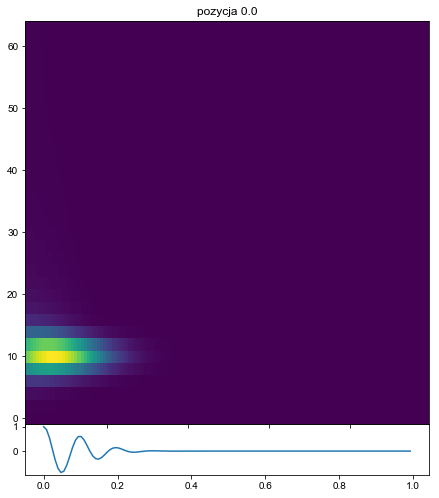

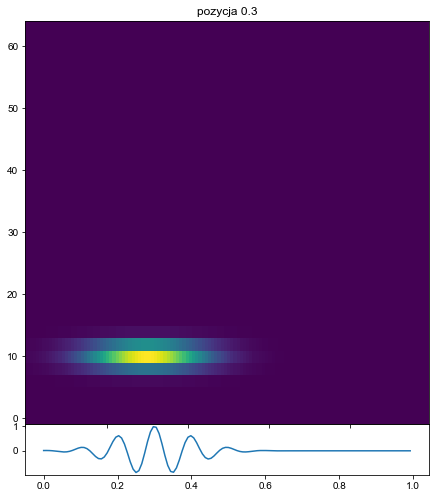

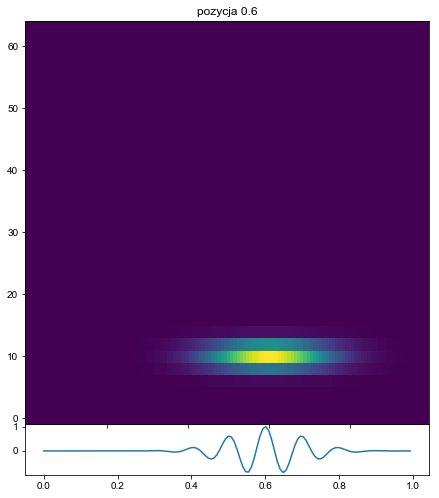

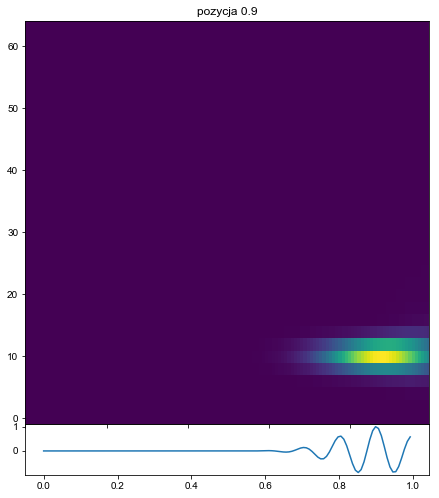

In [7]:
t = czas(T = 1.0, Fs = 128.0)
h=np.hamming(65)
for p in np.arange(0,1,0.3):
    sig1=gabor(t0 = p, sigma = 0.1, T = 1.0, f=10, phi = 0, Fs = 128.0)
    t_mapy, f_mapy, TFR = spektrogram(sig1, h, trans=1 , Fs = 128.0)
    TFRPlot(TFR, t_mapy, f_mapy, sig1, Fs=128.,title ='pozycja '+str(p))

Spektrogram zachowuje przesunięcie w częstości:
$ y(t) = x(t) e ^{i 2 \pi f_0 t}\Rightarrow  S_y(t, f; h) = S_x(t, f - f_0; h) $

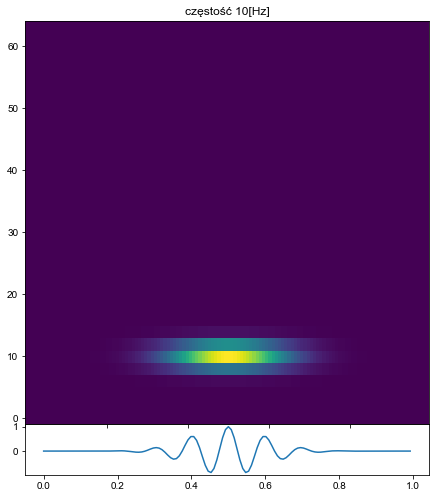

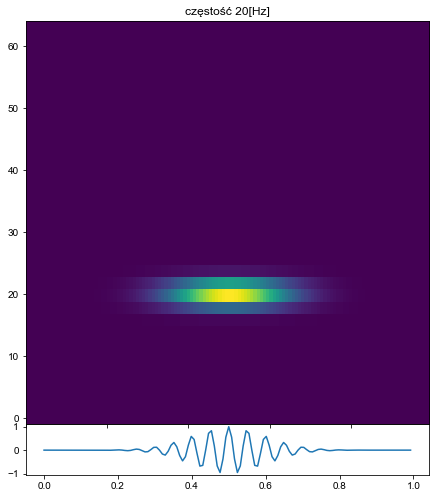

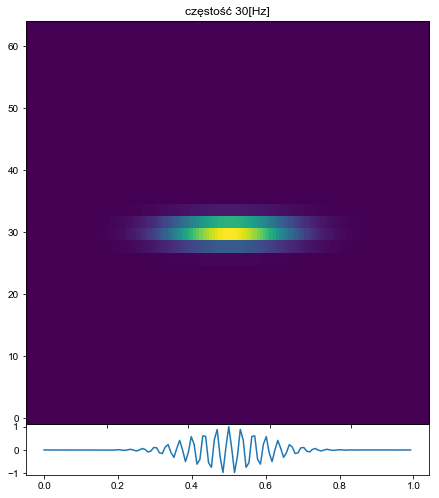

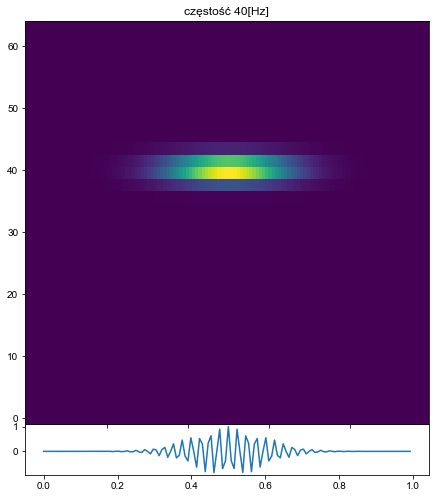

In [8]:
t = czas(T = 1.0, Fs = 128.0)
h=np.hamming(65)
for freq in np.arange(10,50,10):
    sig1=gabor(t0 = 0.5, sigma = 0.1, T = 1.0, f=freq, phi = 0, Fs = 128.0)
    t_mapy, f_mapy, TFR = spektrogram(sig1, h, trans=1 , Fs = 128.0)
    TFRPlot(TFR, t_mapy, f_mapy, sig1, Fs=128.,title ='częstość '+str(freq)+'[Hz]')

### Wyrazy mieszane
* Spektrogram jest reprezentacją kwadratową. 
* Spektrogram sumy sygnałów **nie jest** sumą spektrogramów sygnałów składowych, jest tam jeszcze coś: 

$ y(t) = x_1(t)+x_2(t) \Rightarrow S_y(t, f) = S_{x_1}(t, f)+S_{x_2}(t, f)+2Re\left\{{S_{x_1,x_2}(t, f)}\right\} $

gdzie 

$ S_{x_1,x_2}(t, f) = F_{x_1}(t, f)F^*_{x_2}(t, f) $

Proszę uważnie porównać trzeci z poniższych rysunków z drugim i pierwszym:

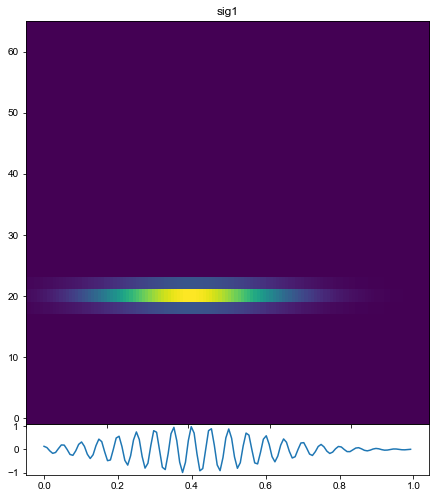

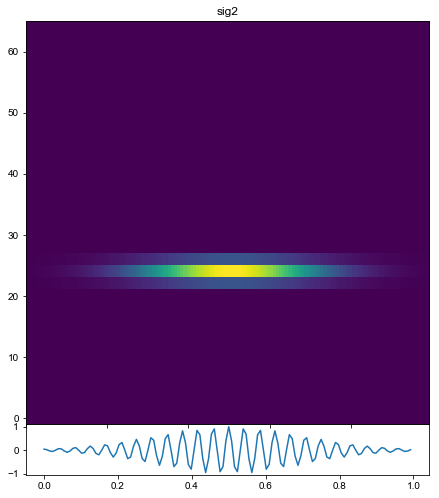

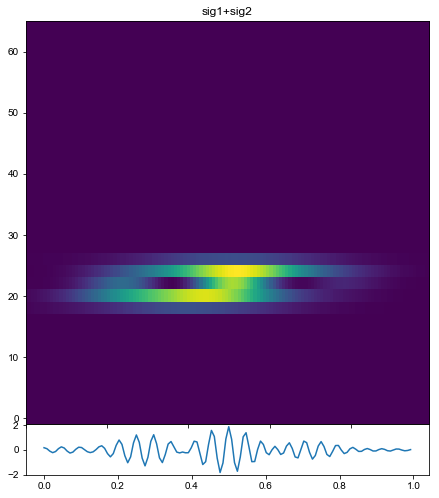

In [9]:
t = czas(T = 1.0, Fs = 128.0)
sig1=gabor(t0 = 0.4, sigma = 0.2, T = 1.0, f=20, phi = 0, Fs = 128.0)
sig2=gabor(t0 = 0.5, sigma = 0.2, T = 1.0, f=24, phi = 0, Fs = 128.0)
h=np.hamming(64)
t_mapy, f_mapy, TFR = spektrogram(sig1, h, trans=1 , Fs = 128.0)
TFRPlot(TFR, t_mapy, f_mapy, sig1, Fs=128,title ='sig1')

t_mapy, f_mapy, TFR = spektrogram(sig2, h, trans=1 , Fs = 128.0)
TFRPlot(TFR, t_mapy, f_mapy, sig2, Fs=128,title ='sig2')

t_mapy, f_mapy, TFR = spektrogram(sig1+sig2, h, trans=1 , Fs = 128.0)
TFRPlot(TFR, t_mapy, f_mapy, sig1+sig2, Fs=128,title ='sig1+sig2')

### Zadanie: Rozdzielczość spektrogramu

* zbadać rozdzielczość czasową i częstotliwościową spektrogramu posługując się poniższym sygnałem testowym 
* wykonać to dla kilku okienek $h$. (hamming, blackman o długościach 16, 32, 64, 128, 256)
* Zaobserwować strukturę cross-termów 

Pytania:
* z jakich struktur składa się analizowany sygnał?
* czy rozdzielczość częstotliwościowa zależy od częstości struktury?
* czy rozdzielczość zależy od długości i typu zastosowanego okienka?

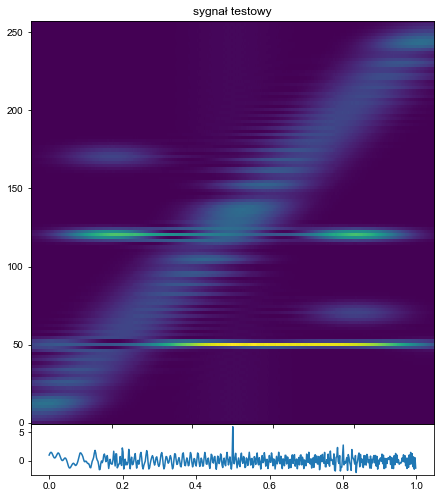

In [10]:
Fs = 512
T = 1
phi = 0
t = czas(T = 1.0, Fs = 512.0)
sig1=gabor(t0 = 0.2, sigma = 0.05, T = T, f=120, phi = phi, Fs = Fs )
sig2=gabor(t0 = 0.2, sigma = 0.025, T = T, f=170, phi = phi, Fs = Fs )
sig3 = chirp(0,256,T,Fs)
sig4=gabor(t0 = 0.8, sigma = 0.05, T = T, f=120, phi = phi, Fs = Fs )
sig5=gabor(t0 = 0.8, sigma = 0.025, T = T, f=70, phi = phi, Fs = Fs )
sig6 = 0.5*sin(f = 50.0, T =T, Fs =Fs, phi = phi)
sig7 = np.zeros(len(t))
sig7[int(len(t)/2)] = 5

sig = sig1+sig2+sig3+sig4+sig5+sig6+sig7
h= np.hamming(256) # okienko
t_mapy, f_mapy, TFR = spektrogram(sig, h, trans=1 , Fs = Fs)
TFRPlot(TFR, t_mapy, f_mapy, sig, Fs=Fs,title ='sygnał testowy')

### Zadanie: spektrogram z EEG
W poniższym przykładzie proszę zbadać wpływ typu i długości okna (64, 128, 256, 1024) na wynik.

w szczególności proszę zwrócić uwagę na obraz struktury oscylacyjnej pomiędzy 6 a 7 sekundą - jest to tzw. wrzeciono snu.

In [11]:
s = np.loadtxt('c4spin.txt')

h = np.hamming(512) # okienko
t_mapy, f_mapy, TFR = spektrogram(s, h, trans=1 , Fs = 128.0)
TFRPlot(TFR, t_mapy, f_mapy, s, Fs=128,title ='EEG')

FileNotFoundError: [Errno 2] No such file or directory: 'c4spin.txt'

## Ciągła transformata falkowa
### Definicja CWT
$ T_x(t,a;\Psi)= \int_{-\infty}^{\infty}{x(s)\Psi^*_{t,a}(s) ds} $

gdzie

$ \Psi_{t,a}(s) = \frac{1}{\sqrt{|a|}} \Psi\left(\frac{s-t}{a}\right) $

$a$ jest skalą. Od falki $\Psi$ wymagamy żeby miała średnią $0$.

Tą transformatę można interpretować jako rzutowanie sygnału na kolejne wersje falki $\Psi$ przesunięte o $t$ i przeskalowane o $a$. 

Dla falek, które są dobrze skupione wokół częstości $f_0$ dla skali $a_0=1$ można wprowadzić  utożsamienie $f=\frac{f_0}{a}$.

Proszę przyjrzeć się definicjom transformaty falkowej i STFT i opowiedzieć o analogiach i różnicach.

#### Jak wygląda falka Morleta

In [ ]:
def falka(f = 10,w=7):
    Fs = 256
    x = np.zeros(2560)
    T= len(x)/Fs
    t = np.arange(0,T,1/Fs)
       
    s = T*f/(2*w)
    xx = np.linspace(-s * 2 * np.pi, s * 2 * np.pi, len(x))
    psi = np.exp(1j * w * xx) * np.exp(-0.5 * (xx**2)) * np.pi**(-0.25) #falka ze skalą odpowiadajacą częstości f
    plt.plot(t,psi.real)
    plt.xlim((0,10))
    plt.show()
falka(f=2, w=30)
#interact(falka, f = (1,17,1),w = (5,11,2))

### Skalogram
Podobnie jak dla STFT i spektrogramu, możemy dla CWT wprowadzić pojęcie skalogramu, będącego estymatą gęstości energii w przestrzeni czas-skala.

$ S_x(t,a;\Psi)=\left| T_x(t,a;\Psi)\right|^2 $

co dzięki związkowi między skalą a częstością można przekształcić w reprezentację czas-częstość:

$S_x(t,f;\Psi)=\left| T_x(t,f_0/f;\Psi)\right|^2 $

### Przykładowa implementacja:

In [12]:
def skalogram(x,  w=7.0, MinF = 1.0 ,MaxF = 64, df=1.0, Fs=128.):
    '''    
    x - sygnał
    w - parametr falki Morleta,
      wiąże się z jej częstością centralną i skalą w nastąpujący sposób:
      f = 2*s*w / T
      gdzie: s-skala,  T-długość sygnału w sek.
      
    MinF,MaxF - częstości pomiędzy którymi ma być liczony skalogram
    df - odstęp pomiędzy częstościami
    Fs - częstość próbkowania
    '''
    T= len(x)/Fs
    M = len(x)
    t = np.arange(0,T,1./Fs)
    freqs = np.arange(MinF,MaxF,df)
    P = np.zeros((len(freqs),M))
    X = np.fft.fft(x)
    for i,f in enumerate(freqs):
        s = T*f/(2*w)
        xx = np.linspace(-s * 2 * np.pi, s * 2 * np.pi, M)
        psi = np.exp(1j * w * xx) * np.exp(-0.5 * (xx**2)) * np.pi**(-0.25) #falka ze skalą odpowiadajacą częstości f
        Psi = np.fft.fft(psi)# transformata falki
        Psi /= np.sqrt(np.sum(Psi*Psi.conj()))  # normalizujemy transformatę falki
        tmp = np.fft.fftshift(np.fft.ifft(X*Psi)) # liczymy odwrotną transformatę od iloczynu transformaty sygnału i transformaty flaki, 
                                                   # czyli liczymy splot sygnału i falki w dziedzinie czasu
        P[i,:] = (tmp*tmp.conj()).real # liczymy moc tego splotu
    return t, freqs, P
 

### Zadanie: Proszę zbadać własności skalogramu w sposób analogiczny jak spektrogramu 

### Zadanie: zbadać własności skalogramu za pomocą naszego próbnego sygnału 
* zbadać jak reprezentacja czas-częstość zależy od parametru falik w $w \in \{7, 10, 15, 20\}$

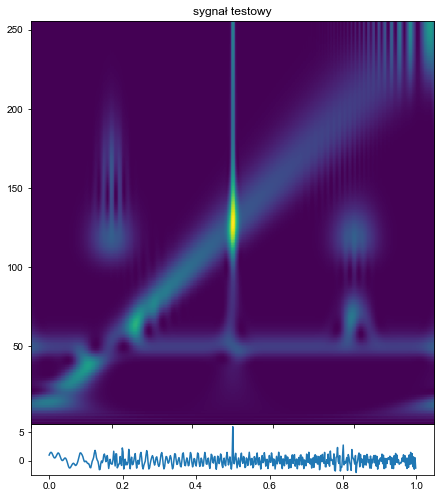

In [13]:
Fs = 512.
T = 1
phi = 0
t = czas(T = 1.0, Fs = 512.0)
sig1=gabor(t0 = 0.2, sigma = 0.05, T = T, f=120, phi = phi, Fs = Fs )
sig2=gabor(t0 = 0.2, sigma = 0.025, T = T, f=170, phi = phi, Fs = Fs )
sig3 = chirp(0,256,T,Fs)
sig4=gabor(t0 = 0.8, sigma = 0.05, T = T, f=120, phi = phi, Fs = Fs )
sig5=gabor(t0 = 0.8, sigma = 0.025, T = T, f=70, phi = phi, Fs = Fs )
sig6 = 0.5*sin(f = 50.0, T =T, Fs =Fs, phi = phi)
sig7 = np.zeros(len(t))
sig7[int(len(t)/2)] = 5

sig = sig1+sig2+sig3+sig4+sig5+sig6+sig7

t_mapy, f_mapy, TFR = skalogram(sig, w= 7, MinF = 1.0, MaxF = Fs/2, df=1.0, Fs=Fs)
TFRPlot(TFR, t_mapy, f_mapy, sig, Fs= Fs,title ='sygnał testowy')

### Zadanie: zbadać zawartość sygnału  EEG za pomocą skalogramu

In [14]:
sig = np.loadtxt('c4spin.txt')
Fs = 128

t_mapy, f_mapy, TFR = skalogram(sig, w=20.0, MinF = 1.0, MaxF = 25, df=0.125, Fs=Fs)
TFRPlot(TFR, t_mapy, f_mapy, s, Fs=128.,title ='EEG')

FileNotFoundError: [Errno 2] No such file or directory: 'c4spin.txt'

### Zadanie: zbadać zawartość sygnału EKG 
Przydadzą nam się pliki: 
* https://drive.google.com/open?id=0BzwQ_Lscn8yDNGc0aU5jSDFFMmc Plik z sygnałem EKG
* https://drive.google.com/open?id=0BzwQ_Lscn8yDOF9jX0pjcG9LSGc Plik z metadanymi do tego sygnału

Proszę:
* wykreślić pierwsze 10 sekund sygnału
* zastosować filtr górnoprzepustowy Butterwartha o częstości odcięcia: 2 Hz 
* Zastosuj spektrogram  z różnymi długościami okna i skalogram z różnymi parametrami falki

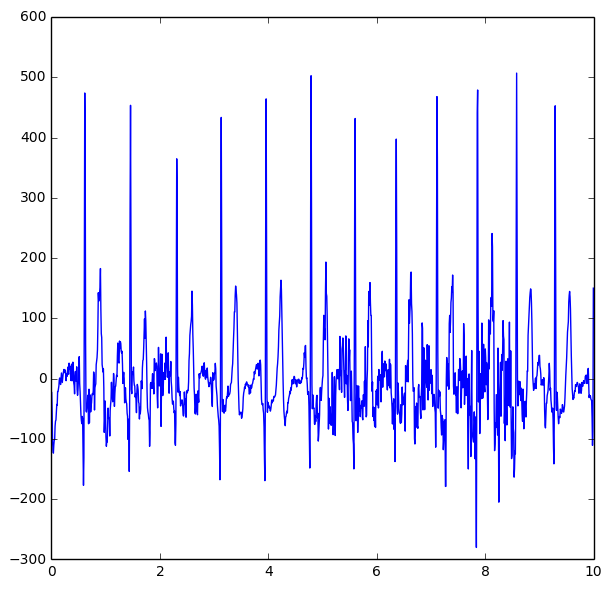

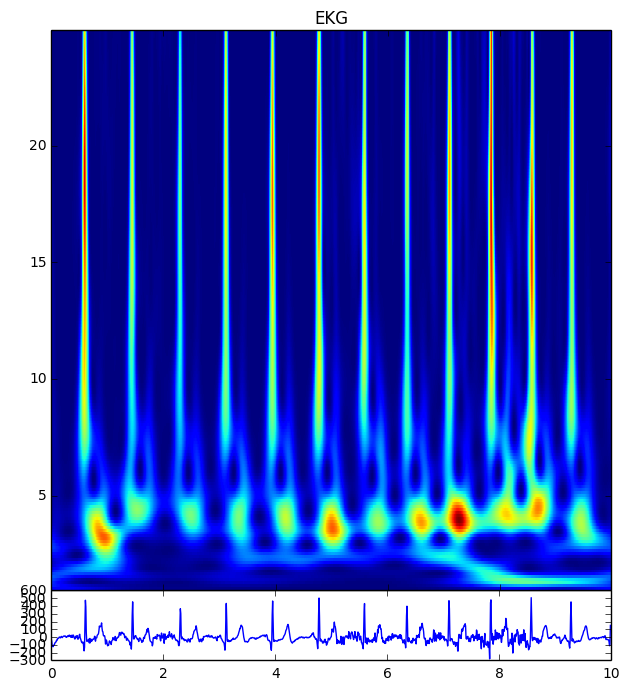

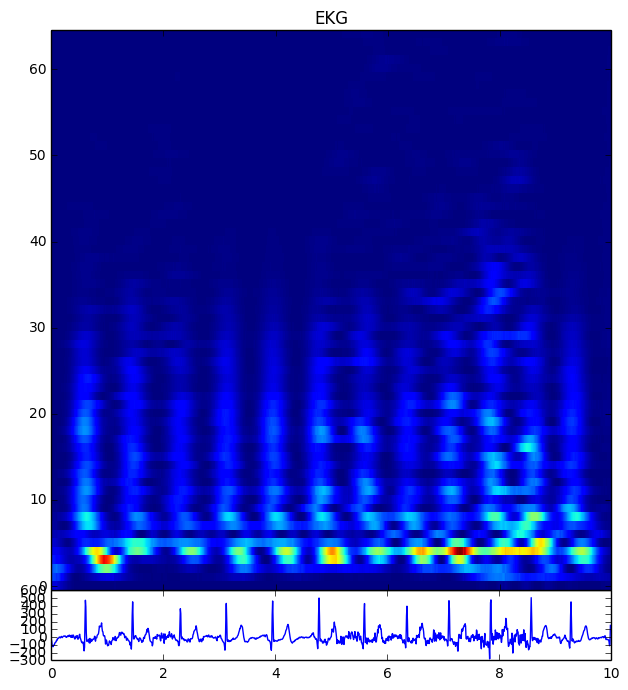

In [13]:
from  scipy.signal import butter
from  scipy.signal import  filtfilt
s = np.fromfile('EKG.bin', dtype='<f') # tworzymy tablicę sig o typie określonym przez ''dtype''                                
# ustawiamy częstość próbkowania
Fs = 128
# tworzymy wektor czasu
t = np.arange(0,len(s))/Fs

# ustalamy zakres indeksów sygnału i czasu do wyświetlania
zakres =  np.logical_and(0<t, t<10)

# filtr górnoprzepustowy (1Hz)
[b,a] = butter(2, 2/(Fs/2), btype = 'highpass' )
sf = filtfilt(b,a,s)
plt.plot(t[zakres],sf[zakres])

plt.show()

t_mapy, f_mapy, TFR = skalogram(sf[zakres], w=5.0, MinF = 1.0, MaxF = 25, df=0.125, Fs=Fs)
TFRPlot(TFR, t_mapy, f_mapy, sf[zakres], Fs=128.,title ='EKG')

h= np.hamming(128)
t_mapy, f_mapy, TFR = spektrogram(sf[zakres], h, trans=1 , Fs = 128.0)
TFRPlot(TFR, t_mapy, f_mapy, sf[zakres], Fs=128,title ='EKG')